**PREVISÃO DA PRODUÇÃO DE ENERGIA SOLAR E EÓLICA NA FRANÇA**

**Este projeto tem como objetivo desenvolver modelos preditivos robustos para estimar a produção horária de energia solar e energia eólica na França, utilizando dados históricos oficiais de geração combinados com variáveis temporais, estatísticas e sazonais derivadas. Com os insights gerados, este projeto permite antecipar padrões de geração, apoiar o planejamento energético estratégico, melhorar a integração à rede elétrica e otimizar o uso de fontes renováveis com maior eficiência e segurança.**

In [1]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from datetime import timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
# Carregando a base de dados
df = pd.read_csv('/content/intermittent-renewables-production-france.csv')

In [3]:
# Observando
df.head()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


In [4]:
df.tail()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
59801,2023-06-30 06:00:00+02:00,2023-06-30,06:00:00,07:00:00,Solar,55.0,181,Friday,June
59802,2023-06-30 13:00:00+02:00,2023-06-30,13:00:00,14:00:00,Solar,4554.0,181,Friday,June
59803,2023-06-30 14:00:00+02:00,2023-06-30,14:00:00,15:00:00,Solar,4589.0,181,Friday,June
59804,2023-06-30 16:00:00+02:00,2023-06-30,16:00:00,17:00:00,Solar,4173.0,181,Friday,June
59805,2023-06-30 18:00:00+02:00,2023-06-30,18:00:00,19:00:00,Solar,2404.0,181,Friday,June


In [5]:
df.shape

(59806, 9)

In [6]:
# Informações sobre os tipos de variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59806 entries, 0 to 59805
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date and Hour  59806 non-null  object 
 1   Date           59806 non-null  object 
 2   StartHour      59806 non-null  object 
 3   EndHour        59806 non-null  object 
 4   Source         59806 non-null  object 
 5   Production     59804 non-null  float64
 6   dayOfYear      59806 non-null  int64  
 7   dayName        59806 non-null  object 
 8   monthName      59806 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.1+ MB


In [7]:
# Verificando a existência de valores nulos
df.isnull().sum()

,0
Date and Hour,0
Date,0
StartHour,0
EndHour,0
Source,0
Production,2
dayOfYear,0
dayName,0
monthName,0


In [8]:
# Remover linhas onde 'Production' é nulo
df = df.dropna(subset=['Production'])

In [9]:
df.isnull().sum()

,0
Date and Hour,0
Date,0
StartHour,0
EndHour,0
Source,0
Production,0
dayOfYear,0
dayName,0
monthName,0


In [10]:
# Converter coluna 'Date and Hour' para datetime
df['Date and Hour'] = pd.to_datetime(df['Date and Hour'])

# Ordenar cronologicamente (boa prática para séries temporais)
df = df.sort_values('Date and Hour')

# Setar como índice
df.set_index('Date and Hour', inplace=True)

In [11]:
# Remover colunas que não vamos usar agora
df.drop(columns=['Date', 'StartHour', 'EndHour'], inplace=True)

In [12]:
 # Corrigir o índice, convertendo com utc=True para evitar erro
df.index = pd.to_datetime(df.index, utc=True)

# Agora sim, você pode criar as features temporais
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

In [13]:
df.drop(columns=['dayName', 'monthName'], inplace=True)

In [14]:
df.head()

,Source,Production,dayOfYear,hour,dayofweek,month
Date and Hour,,,,,,
2019-12-31 23:00:00+00:00,Solar,0.0,1,23,1,12
2019-12-31 23:00:00+00:00,Wind,3549.0,1,23,1,12
2020-01-01 00:00:00+00:00,Wind,2952.0,1,0,2,1
2020-01-01 00:00:00+00:00,Solar,0.0,1,0,2,1
2020-01-01 01:00:00+00:00,Wind,2722.0,1,1,2,1


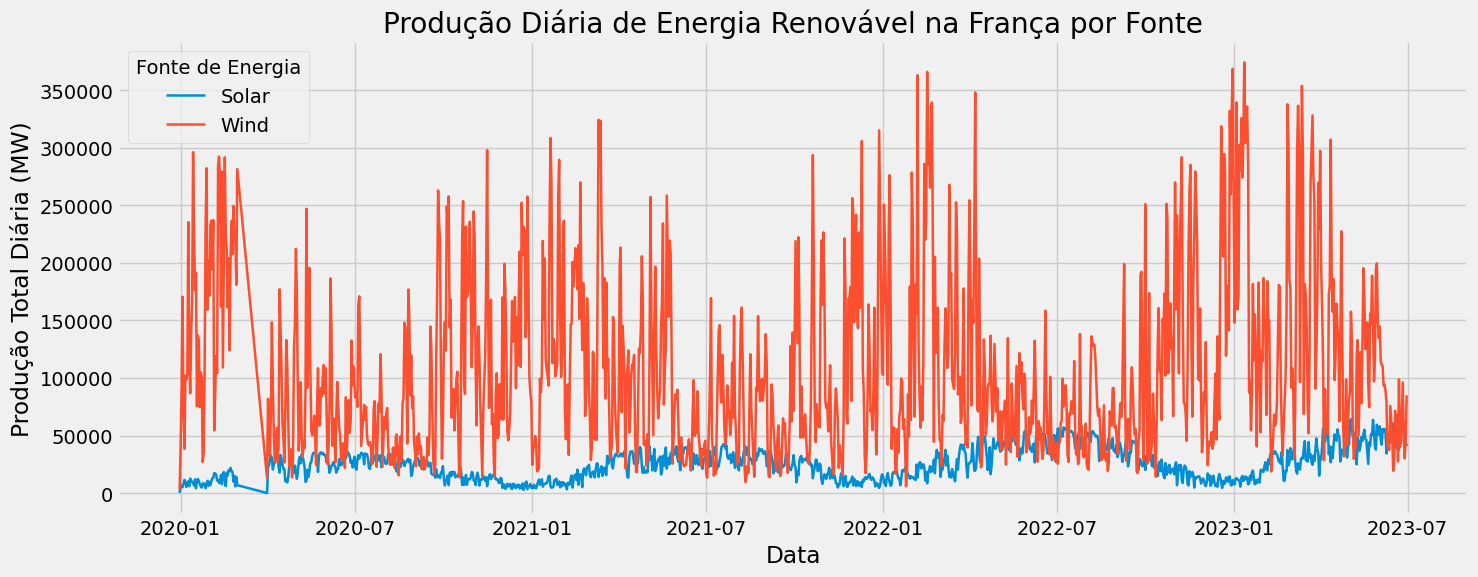

In [15]:
# Agrupar por dia e somar a produção por fonte
df_daily = df.pivot_table(values='Production', index=df.index.date, columns='Source', aggfunc='sum')

# Plotar a produção diária de energia por fonte
plt.figure(figsize=(15, 6))
for col in df_daily.columns:
    plt.plot(df_daily.index, df_daily[col], label=col, linewidth=1.8)

plt.title('Produção Diária de Energia Renovável na França por Fonte')
plt.xlabel('Data')
plt.ylabel('Produção Total Diária (MW)')
plt.legend(title='Fonte de Energia')
plt.grid(True)
plt.tight_layout()
plt.show()

**O gráfico acima apresenta a produção total diária de energia renovável na França, separada por fonte: Solar e Wind (que agrega eólica onshore e offshore). A análise revela padrões distintos entre as duas fontes:**

**Energia Solar:** Exibe um comportamento altamente sazonal, com produção crescente nos meses de verão (junho a agosto) e declínio acentuado no inverno (dezembro a fevereiro). O padrão é regular e previsível, tornando essa fonte ideal para modelos de previsão baseados em ciclos temporais.

**Energia Eólica:** Apresenta uma variabilidade muito mais acentuada, com picos e quedas diárias de grande amplitude. Apesar de mais irregular, a produção eólica mantém níveis relevantes ao longo de todo o ano, indicando sua importância contínua no mix energético francês.

In [16]:
# Dividir o dataframe por tipo de fonte
df_solar = df[df['Source'] == 'Solar'].copy()
df_wind = df[df['Source'] == 'Wind'].copy()

In [17]:
df_solar.head()

,Source,Production,dayOfYear,hour,dayofweek,month
Date and Hour,,,,,,
2019-12-31 23:00:00+00:00,Solar,0.0,1,23,1,12
2020-01-01 00:00:00+00:00,Solar,0.0,1,0,2,1
2020-01-01 01:00:00+00:00,Solar,0.0,1,1,2,1
2020-01-01 02:00:00+00:00,Solar,0.0,1,2,2,1
2020-01-01 03:00:00+00:00,Solar,0.0,1,3,2,1


<Figure size 1400x800 with 0 Axes>

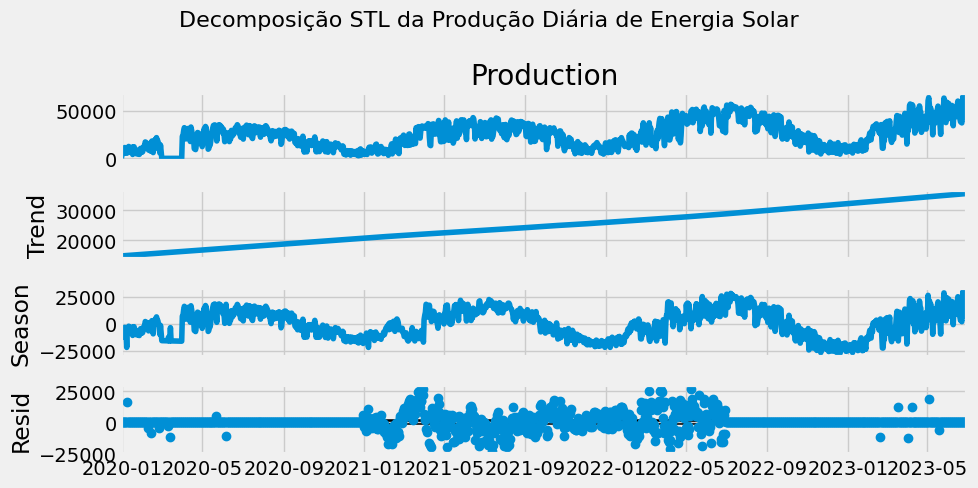

In [18]:
# Agregar produção por dia (somar todas as horas)
solar_daily = df_solar['Production'].resample('D').sum()

# Aplicar STL (Seasonal-Trend decomposition using Loess)
stl = STL(solar_daily, period=365, robust=True)
result = stl.fit()

# Plotar os componentes
plt.figure(figsize=(14, 8))
result.plot()
plt.suptitle('Decomposição STL da Produção Diária de Energia Solar', fontsize=16)
plt.tight_layout()
plt.show()

**Acima observamos:**

**Trend (tendência):** Observa-se um crescimento constante na produção diária de energia solar ao longo dos anos. Esse aumento pode estar relacionado à expansão da capacidade instalada no país, seja pela adição de novas usinas solares, avanços tecnológicos ou incentivos governamentais voltados à transição energética.

**Season (sazonalidade):** O padrão sazonal é bem definido e estável, refletindo a variação natural da radiação solar ao longo do ano. Notamos que os picos ocorrem nos meses de verão, enquanto os vales aparecem no inverno, com produção próxima de zero. Esse comportamento reforça o caráter cíclico da fonte solar e sua alta previsibilidade.

**Resid (ruídos):** Os resíduos mostram variações pontuais esperadas para esse tipo de geração, como dias nublados, manutenção ou possíveis falhas no registro. Não há nenhum padrão anômalo significativo, exceto por uma leve dispersão mais acentuada entre 2021 e 2022, possivelmente relacionada a fatores climáticos ou operacionais.

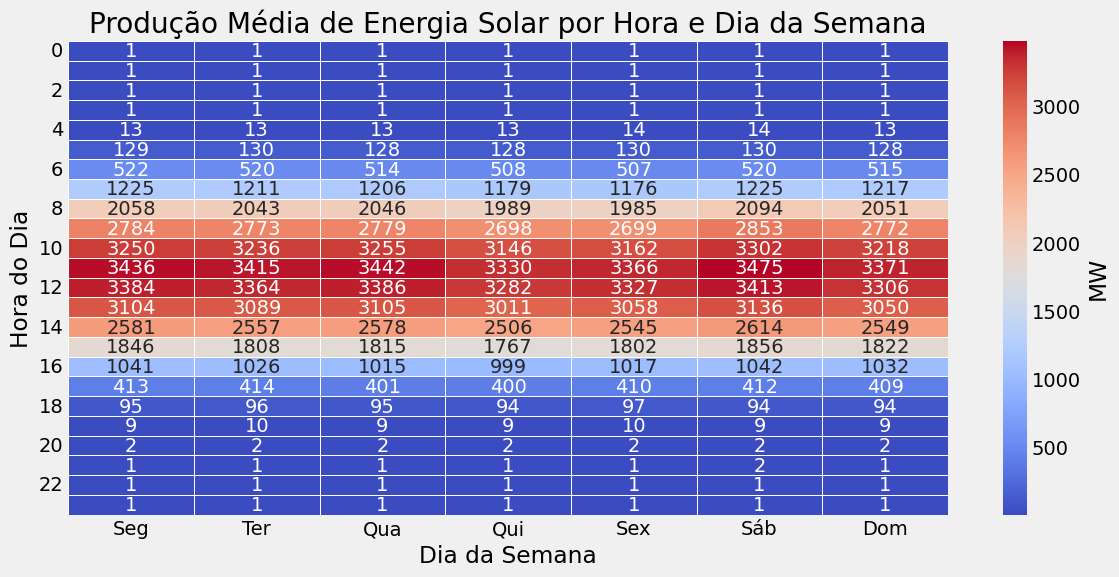

In [19]:
# Criar um DataFrame auxiliar só com as variáveis temporárias
df_temp = pd.DataFrame({
    'Production': df_solar['Production'].values,
    'hour': df_solar.index.hour,
    'dayofweek': df_solar.index.dayofweek
})

# Mapear nomes dos dias da semana
dias_nome = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
df_temp['day_name'] = df_temp['dayofweek'].map(lambda x: dias_nome[x])

# Criar pivot_table para o heatmap
pivot_table = df_temp.pivot_table(values='Production',
                                  index='hour',
                                  columns='day_name',
                                  aggfunc='mean')

# Reordenar colunas na ordem correta dos dias da semana
pivot_table = pivot_table[['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']]

# Plotar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'MW'})
plt.title('Produção Média de Energia Solar por Hora e Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Acima percebemos que a janela útil de geração vai de 6h até 18h, com pico entre as 8h até 15h e máxima absoluta que ocorre às 12h e 13h, com média superior a 3400 MW.**

In [20]:
# Função para identificar a estação do ano
def estacao_do_ano(data):
    mes = data.month
    dia = data.day
    if (mes == 12 and dia >= 21) or (mes in [1, 2]) or (mes == 3 and dia < 21):
        return 'Inverno'
    elif (mes == 3 and dia >= 21) or (mes in [4, 5]) or (mes == 6 and dia < 21):
        return 'Primavera'
    elif (mes == 6 and dia >= 21) or (mes in [7, 8]) or (mes == 9 and dia < 21):
        return 'Verão'
    else:
        return 'Outono'

# Criar coluna com estação do ano
df_solar['estacao'] = df_solar.index.map(estacao_do_ano)

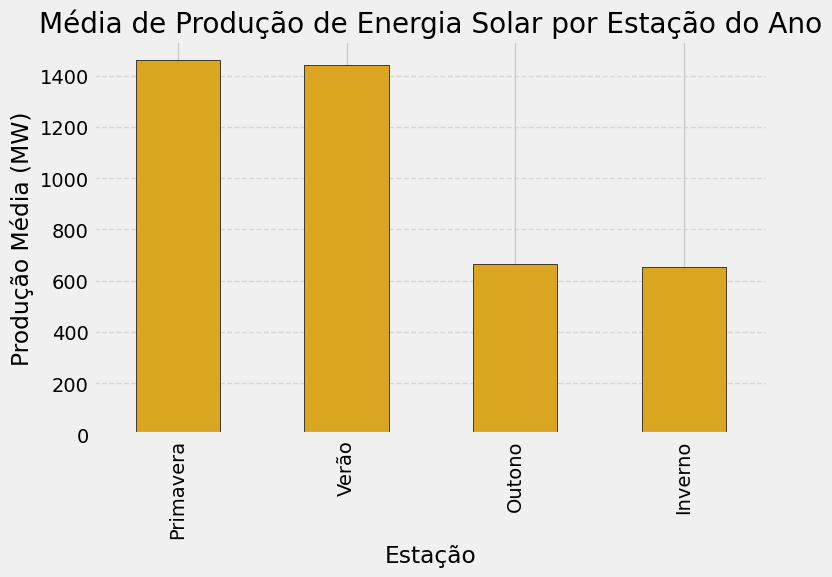

In [21]:
# Reordenar estações manualmente (opcional, para manter a sequência lógica)
ordem_estacoes = ['Primavera', 'Verão', 'Outono', 'Inverno']
# Calcular média de produção por estação
media_por_estacao = df_solar.groupby('estacao')['Production'].mean().sort_values(ascending=False)
media_por_estacao = media_por_estacao.reindex(ordem_estacoes)

# Plotar gráfico de barras
plt.figure(figsize=(8, 6))
media_por_estacao.plot(kind='bar', color='goldenrod', edgecolor='black')

plt.title('Média de Produção de Energia Solar por Estação do Ano')
plt.xlabel('Estação')
plt.ylabel('Produção Média (MW)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**O gráfico acima nos diz claramente que na primavera e no verão ocorre maior produção de energia solar com média diária acima de 1400 MW. No outono e no inverno vemos uma produção muito inferior, reforçando o impacto da radiação solar e inclinação do sol no hemisfério norte durante os meses mais frios.**

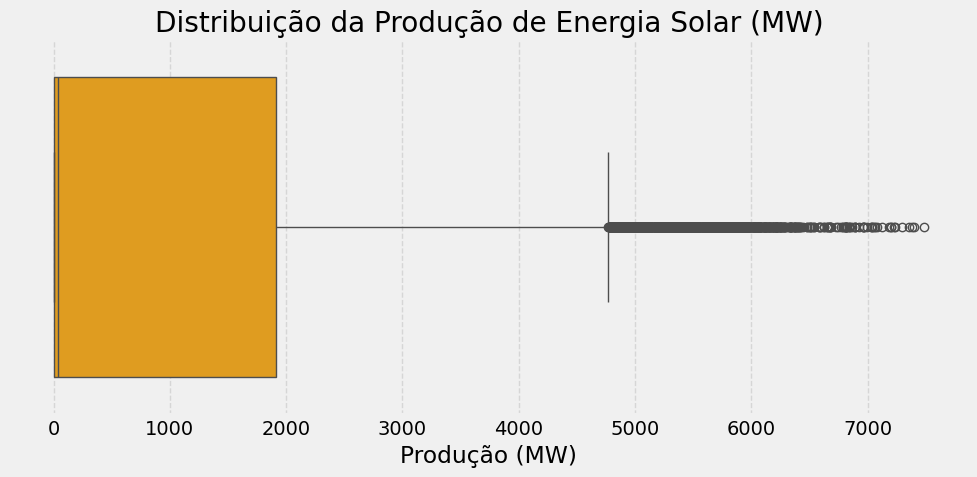

In [22]:
# Boxplot da produção solar total
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_solar['Production'], color='orange')
plt.title('Distribuição da Produção de Energia Solar (MW)')
plt.xlabel('Produção (MW)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
# Calcular limites usando o método interquartil (IQR)
Q1 = df_solar['Production'].quantile(0.25)
Q3 = df_solar['Production'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR  # Normalmente não ocorre no solar, mas colocamos por robustez

# Criar a variável is_outlier
df_solar['is_outlier'] = ((df_solar['Production'] > limite_superior) |
                          (df_solar['Production'] < limite_inferior)).astype(int)

In [24]:
# Criar versões cíclicas
df_solar['hour_sin'] = np.sin(2 * np.pi * df_solar['hour'] / 24)
df_solar['hour_cos'] = np.cos(2 * np.pi * df_solar['hour'] / 24)

df_solar['dayofweek_sin'] = np.sin(2 * np.pi * df_solar['dayofweek'] / 7)
df_solar['dayofweek_cos'] = np.cos(2 * np.pi * df_solar['dayofweek'] / 7)

df_solar['month_sin'] = np.sin(2 * np.pi * df_solar['month'] / 12)
df_solar['month_cos'] = np.cos(2 * np.pi * df_solar['month'] / 12)

In [25]:
df_solar.drop(columns=['hour', 'dayofweek', 'month', 'Source'], inplace=True)

**Vamos criar legs temporais para ajudar o modelo a capturar padrões de persistência, tendência e ciclos de curto prazo, que são comuns em séries temporais. lag_1 representa a produção da última hora, lag_2 das últimas 2h...Esse histórico é essencial para que o modelo aprenda o comportamento recorrente da série ao longo do tempo e possa fazer previsões mais precisas**

In [26]:
# Legs temporais
for lag in [1, 2, 3, 6, 12, 24]:
    df_solar[f'lag_{lag}'] = df_solar['Production'].shift(lag)


**As médias móveis que vamos criar (rolling_mean) e os desvios padrão móveis (rolling_std) são usadas para capturar o comportamento local da série temporal, ou seja, como a produção de energia tem se comportado nas últimas horas. rolling_mean_6h: média da produção nas últimas 6 horas, mostra a tendência recente: rolling_std_6h: desvio padrão nas últimas 6 horas, mostra a variabilidade (ou estabilidade) recente. Essas variáveis ajudam o modelo a entender se a produção está em alta, baixa ou instável, fornecendo contexto dinâmico para a previsão.**

In [27]:
# Medias móveis
df_solar['rolling_mean_6h'] = df_solar['Production'].rolling(6).mean()
df_solar['rolling_mean_12h'] = df_solar['Production'].rolling(12).mean()
df_solar['rolling_std_6h'] = df_solar['Production'].rolling(6).std()
df_solar['rolling_std_12h'] = df_solar['Production'].rolling(12).std()


**A amplitude diária é a diferença entre o valor máximo e o mínimo da produção de energia em cada dia. Ela serve para capturar a variação total da produção solar ao longo do dia. Essa informação é útil porque dias com alta amplitude geralmente indicam céu limpo, com muita radiação solar (produção intensa ao meio-dia e baixa à noite). Já uma amplitude baixa pode indicar tempo nublado ou dias com pouca variação de luz solar. Com isso, o modelo entende o perfil climático e de produção daquele dia, o que ajuda bastante a melhorar a previsão, especialmente nos extremos (picos e vales).**

In [28]:
# Amplitude diária
df_solar['daily_max'] = df_solar['Production'].groupby(df_solar.index.date).transform('max')
df_solar['daily_min'] = df_solar['Production'].groupby(df_solar.index.date).transform('min')
df_solar['daily_amp'] = df_solar['daily_max'] - df_solar['daily_min']

**Vamos criar a variável is_peak_solar_hour que será uma flag binária que indica se a hora registrada está dentro do horário de pico solar, geralmente entre 10h e 15h.**

In [29]:
# Variável binária para horário de pico solar
df_solar['is_peak_solar_hour'] = ((df_solar.index.hour >= 10) & (df_solar.index.hour <= 15)).astype(int)


In [30]:
df_solar.dropna(inplace=True)

In [31]:
total_acima_6000 = (df_solar['Production'] > 6000).sum()
print(f"Total geral de valores > 6000: {total_acima_6000}")

Total geral de valores > 6000: 198


In [32]:
# Remover os registros com produção acima de 6000
df_solar = df_solar[df_solar['Production'] <= 6000].copy()

In [33]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29679 entries, 2020-01-01 23:00:00+00:00 to 2023-06-30 21:00:00+00:00
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Production          29679 non-null  float64
 1   dayOfYear           29679 non-null  int64  
 2   estacao             29679 non-null  object 
 3   is_outlier          29679 non-null  int64  
 4   hour_sin            29679 non-null  float64
 5   hour_cos            29679 non-null  float64
 6   dayofweek_sin       29679 non-null  float64
 7   dayofweek_cos       29679 non-null  float64
 8   month_sin           29679 non-null  float64
 9   month_cos           29679 non-null  float64
 10  lag_1               29679 non-null  float64
 11  lag_2               29679 non-null  float64
 12  lag_3               29679 non-null  float64
 13  lag_6               29679 non-null  float64
 14  lag_12              29679 non-null  float64
 15  lag_24

In [34]:
# Aplicar One-Hot Encoding na variável 'estacao'
df_solar = pd.get_dummies(df_solar, columns=['estacao'], prefix='estacao', dtype=np.uint8)

# Checar se ainda há NaNs
print("Tem NaNs?", df_solar.isnull().sum().sum() > 0)


Tem NaNs? False


In [35]:
# Separar variável alvo
y = df_solar['Production']

# Separar preditoras (removendo a coluna alvo)
X = df_solar.drop(columns=['Production'])

In [36]:
# Tamanhos da base
n_total = len(X)
n_treino = int(n_total * 0.7)
n_val = int(n_total * 0.15)
n_teste = n_total - n_treino - n_val

# Separar em ordem cronológica
X_train = X.iloc[:n_treino]
y_train = y.iloc[:n_treino]

X_val = X.iloc[n_treino:n_treino+n_val]
y_val = y.iloc[n_treino:n_treino+n_val]

X_test = X.iloc[n_treino+n_val:]
y_test = y.iloc[n_treino+n_val:]

# Confirmar as dimensões
print(f'Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}')

Treino: (20775, 26), Validação: (4451, 26), Teste: (4453, 26)


**A padronização é aplicada apenas às variáveis contínuas porque elas possuem escalas numéricas diferentes, o que pode confundir o modelo durante o treinamento. Ao padronizar, colocamos todas essas variáveis na mesma base (média 0 e desvio padrão 1), facilitando o aprendizado. Já as variáveis categóricas (como as estações do ano codificadas com One-Hot) e binárias (como is_outlier) não precisam ser padronizadas. Elas já estão em uma escala consistente (valores 0 ou 1), e padronizar esses valores poderia atrapalhar a interpretação do modelo.**

In [37]:
# Identificando colunas numéricas contínuas (sem one-hot nem binárias)
cols_to_scale = X_train.select_dtypes(include=['float64', 'int64']).columns
cols_to_scale = [col for col in cols_to_scale if not col.startswith('estacao_') and col != 'is_outlier']

# Inicializaando o scaler somente no treino
scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Aplicando transformação no val e teste
X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [38]:
# Threshold para definir picos
threshold_peak = np.percentile(y_train, 80)

**Vamos usar uma estratégia híbrida com dois modelos especializados, um para dados normais e outro para os picos de produção, por isso é importante que cada modelo receba seus dados padronizados de forma adequada. Se utlizarmos o mesmo scaler para todos os dados, os valores muito altos (os picos) ficariam distorcidos pela média geral, dificultando o aprendizado do modelo de picos. Por isso, vamos escalonar separadamente: Modelo de dados normais vai receber os dados padronizados com base apenas na distribuição dos valores normais. O modelo de picos vai receber os dados padronizados com base apenas nos dados de pico. Essa separação permite que cada modelo aprenda com mais precisão a faixa específica que deve prever, melhorando o desempenho geral da solução.**

In [39]:
# Separar os dados entre normais e picos
idx_normais = y_train <= threshold_peak
idx_picos = y_train > threshold_peak

# Escalonar separadamente
scaler_normais = StandardScaler()
X_train_normais_scaled = scaler_normais.fit_transform(X_train[idx_normais])
y_train_normais = y_train[idx_normais]

scaler_picos = StandardScaler()
X_train_picos_scaled = scaler_picos.fit_transform(X_train[idx_picos])
y_train_picos = y_train[idx_picos]

In [40]:
# Modelos base
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=2, random_state=42)),
    ('lasso', Lasso(alpha=0.1, max_iter=10000, random_state=42))
]
meta_model = LinearRegression()

# Modelo empilhado para normais
model_normais = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    n_jobs=-1
)
model_normais.fit(X_train_normais_scaled, y_train_normais)

# Modelo XGBoost para picos
model_picos = XGBRegressor(n_estimators=300, max_depth=10, learning_rate=0.05,
                           objective='reg:squarederror', random_state=42)
model_picos.fit(X_train_picos_scaled, y_train_picos)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
# Escalonar dados de validação e teste
X_val_normais_scaled = scaler_normais.transform(X_val)
X_val_picos_scaled = scaler_picos.transform(X_val)
X_test_normais_scaled = scaler_normais.transform(X_test)
X_test_picos_scaled = scaler_picos.transform(X_test)

In [42]:
# Previsões
y_val_pred_normais = model_normais.predict(X_val_normais_scaled)
y_val_pred_picos = model_picos.predict(X_val_picos_scaled)
y_test_pred_normais = model_normais.predict(X_test_normais_scaled)
y_test_pred_picos = model_picos.predict(X_test_picos_scaled)

In [43]:
# Combinar: se previsão do modelo normal indicar pico, usamos o XGBoost
y_val_pred_hibrido = np.where(y_val_pred_normais > threshold_peak, y_val_pred_picos, y_val_pred_normais)
y_test_pred_hibrido = np.where(y_test_pred_normais > threshold_peak, y_test_pred_picos, y_test_pred_normais)

In [44]:
# Avaliação - Validação
mae_val = mean_absolute_error(y_val, y_val_pred_hibrido)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred_hibrido))
r2_val = r2_score(y_val, y_val_pred_hibrido)

print("📊 Avaliação - Validação (Modelo Empilhado Híbrido)")
print(f"MAE:  {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"R²:   {r2_val:.4f}")
print("-" * 30)

# Avaliação - Teste
mae_test = mean_absolute_error(y_test, y_test_pred_hibrido)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_hibrido))
r2_test = r2_score(y_test, y_test_pred_hibrido)

print("📊 Avaliação - Teste (Modelo Empilhado Híbrido)")
print(f"MAE:  {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²:   {r2_test:.4f}")
print("-" * 30)

📊 Avaliação - Validação (Modelo Empilhado Híbrido)
MAE:  78.72
RMSE: 106.20
R²:   0.9964
------------------------------
📊 Avaliação - Teste (Modelo Empilhado Híbrido)
MAE:  98.66
RMSE: 152.68
R²:   0.9924
------------------------------


**MAE (Erro Médio Absoluto):** Em média, o modelo comete um erro de 78.72 unidades de energia na validação e 98.66 no teste. Considerando que a produção diária pode ultrapassar facilmente os 6000, esses valores são extremamente baixos, o que indica alta precisão nas previsões. A diferença pequena entre validação e teste também é um ótimo sinal de generalização, sem overfitting.

**RMSE (Raiz do Erro Quadrático Médio):** Como esperado, o RMSE é um pouco maior que o MAE (106.20 na validação e 152.68 no teste), o que mostra que o modelo não cometeu grandes erros nos picos. Mesmo nos casos extremos, o modelo se manteve bem calibrado, controlando desvios fora da média.

**R² (Coeficiente de Determinação):** O modelo explica 99.64% da variância na validação e 99.24% no teste, ou seja, praticamente toda a variabilidade da produção solar foi capturada. Isso mostra que o modelo aprendeu padrões reais e generalizou de forma excelente, sendo altamente confiável para tomada de decisão.

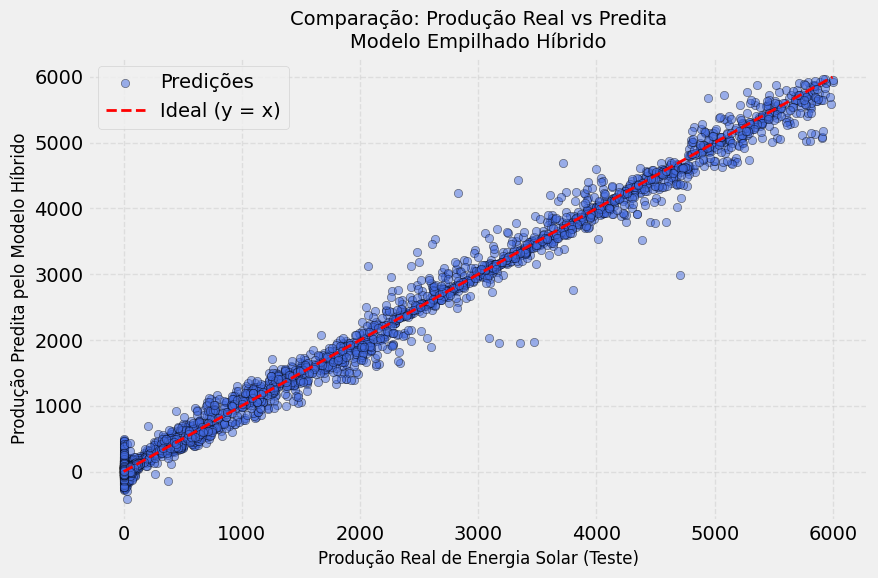

In [45]:
# Gráfico de dispersão: valores reais vs preditos no teste
plt.figure(figsize=(9, 6))
plt.scatter(y_test, y_test_pred_hibrido, alpha=0.5, color='royalblue', edgecolors='k', label='Predições')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Ideal (y = x)')
plt.xlabel("Produção Real de Energia Solar (Teste)", fontsize=12)
plt.ylabel("Produção Predita pelo Modelo Híbrido", fontsize=12)
plt.title("Comparação: Produção Real vs Predita\nModelo Empilhado Híbrido", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**O gráfico acima mostra a relação entre os valores reais de produção de energia solar e as predições geradas pelo modelo empilhado híbrido. A linha tracejada vermelha representa a linha ideal (y = x), onde os pontos estariam perfeitamente previstos. A proximidade dos pontos à linha ideal indica alta precisão nas previsões. Observa-se que o modelo conseguiu capturar bem a tendência geral e os picos de produção, com leve dispersão aceitável em alguns extremos, o que reforça o excelente desempenho mostrado pelas métricas (R² acima de 0.99).**

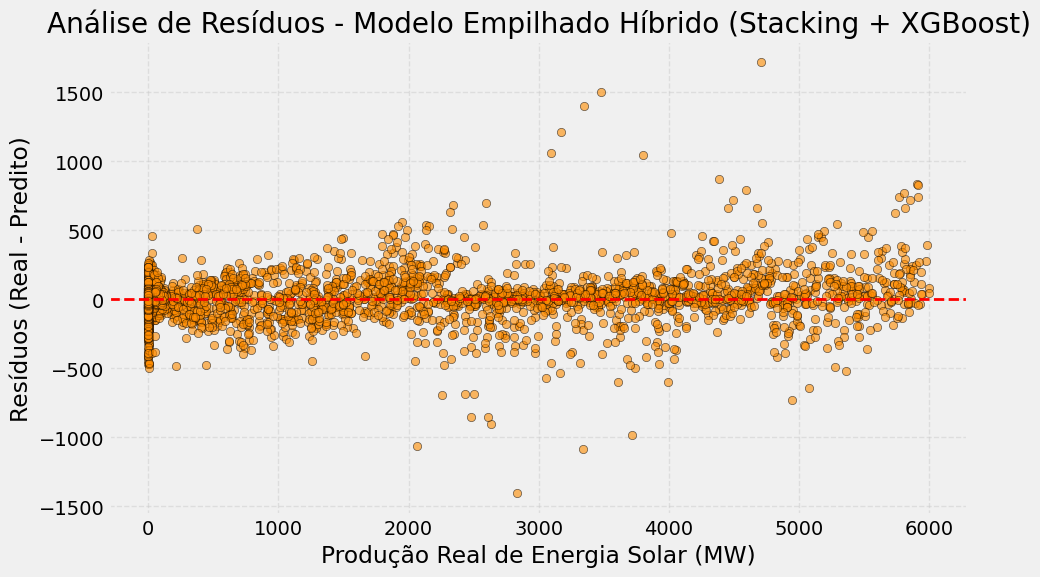

In [46]:
# Calculando os resíduos do modelo híbrido no conjunto de teste
residuos_hibrido = y_test - y_test_pred_hibrido

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuos_hibrido, color='darkorange', alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Produção Real de Energia Solar (MW)")
plt.ylabel("Resíduos (Real - Predito)")
plt.title("Análise de Resíduos - Modelo Empilhado Híbrido (Stacking + XGBoost)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**O gráfico acima mostra a distribuição dos resíduos (diferença entre valores reais e preditos) em relação à produção real de energia solar. A maior parte dos pontos está concentrada próxima da linha zero, indicando que o modelo está bem calibrado e os erros são majoritariamente pequenos. Embora haja maior dispersão nos extremos da produção, o padrão geral não apresenta viés sistemático, o que é desejável em modelos robustos.**

**Agora vamos criar um forecast de 15 dias futuros e para melhorar a qualidade, utilizamos uma abordagem híbrida composta por dois estágios. Primeiro, aplicamos o modelo empilhado (Stacking + XGBoost) para gerar a previsão base da produção solar. Em seguida, treinamos uma rede neural LSTM com os resíduos históricos (diferença entre valores reais e previstos) para aprender padrões recorrentes de erro. A LSTM vai atuar como um meta-aprendizado, ajustando a previsão base ponto a ponto. Essa correção permite capturar desvios sistemáticos do modelo principal, principalmente em cenários complexos como transições climáticas ou mudanças bruscas de produção. O resultado é um forecast mais aderente à realidade, com melhor acompanhamento dos padrões temporais e dos picos de produção.**

In [47]:
# Preparando histórico de predições e resíduos
history_window = 48  # últimas 48 horas
history_steps = 24 * 30  # 30 dias (720 horas)
y_pred_hist = y_test_pred_hibrido[-history_steps:]
y_true_hist = y_test.iloc[-history_steps:]
residuos_hist = y_true_hist.values - y_pred_hist

# Criando sequências para treinar LSTM (entrada = predições híbridas, saída = erro)
X_seq, y_seq = [], []
for i in range(history_window, len(y_pred_hist)):
    X_seq.append(y_pred_hist[i-history_window:i])
    y_seq.append(residuos_hist[i])

X_seq = np.array(X_seq)[..., np.newaxis]  # (amostras, janela, 1)
y_seq = np.array(y_seq)

# Treinando modelo LSTM para corrigir os erros
model_lstm = Sequential([
    LSTM(64, input_shape=(history_window, 1)),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(0.001), loss='mse')
model_lstm.fit(X_seq, y_seq, epochs=30, verbose=1)

# Forecast de 15 dias com predição híbrida + ajuste via LSTM
future_steps = 24 * 15  # 15 dias
base_forecast = y_test_pred_hibrido[-future_steps:] if len(y_test_pred_hibrido) >= future_steps else np.full(future_steps, y_test_pred_hibrido[-1])
refined_forecast = []

base_seq = list(y_pred_hist[-history_window:])  # sequência base pra iniciar

for i in range(future_steps):
    x_input = np.array(base_seq[-history_window:]).reshape(1, history_window, 1)
    predicted_resid = model_lstm.predict(x_input, verbose=0)[0][0]
    corrected_value = base_forecast[i] + predicted_resid
    refined_forecast.append(corrected_value)
    base_seq.append(corrected_value)

# Organizar o DataFrame com previsões
start_date = y_test.index[-1] + pd.Timedelta(hours=1)
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='H')
df_forecast_lstm = pd.DataFrame({'Forecast': refined_forecast}, index=future_dates)


Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 27870.1250
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 32667.3164
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 39352.6133
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 32500.7598
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 33339.8164
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 32687.6699
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 34048.6289
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 37492.4883
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 34685.8203
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 43007.6797
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 41240.1562
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 38850.7109
Epoch 13/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 41727.3203
Epoch 14/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 30920.4355
Epoch 15/30
21/

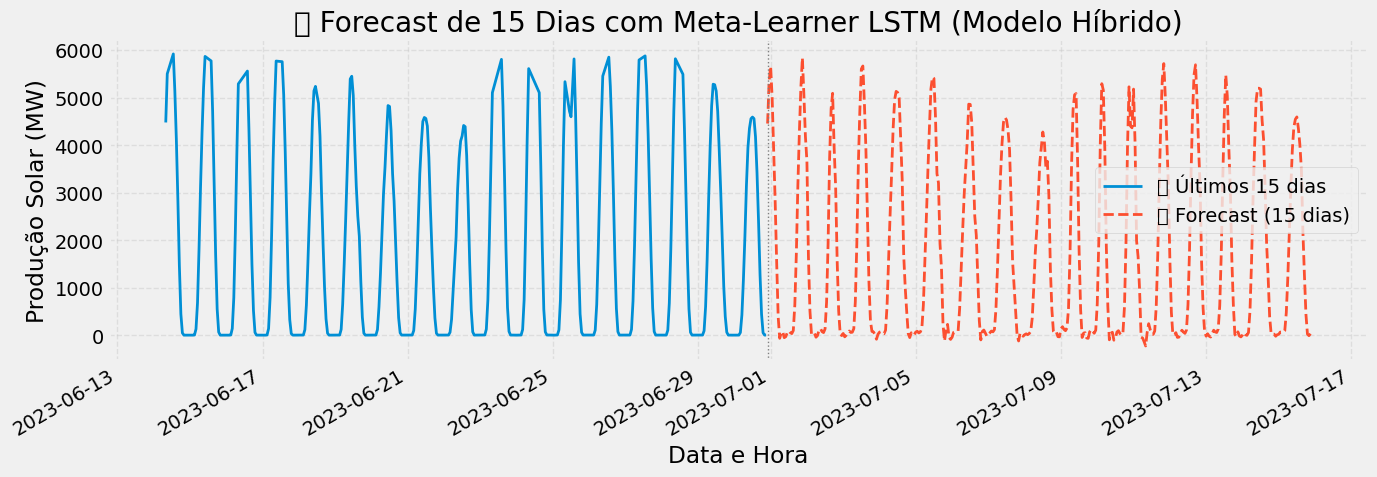

In [48]:
# Observando o gráfico
plt.figure(figsize=(14, 5))
y_test[-24*15:].plot(label='🔵 Últimos 15 dias', linewidth=2)
df_forecast_lstm['Forecast'].plot(label='🔶 Forecast (15 dias)', linestyle='--', linewidth=2)
plt.axvline(x=df_forecast_lstm.index[0], color='gray', linestyle=':', linewidth=1)
plt.title('🔮 Forecast de 15 Dias com Meta-Learner LSTM (Modelo Híbrido)')
plt.ylabel('Produção Solar (MW)')
plt.xlabel('Data e Hora')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**O gráfico acima apresenta a comparação entre os últimos 15 dias reais de produção solar (linha azul) e a previsão para os próximos 15 dias (linha laranja tracejada), utilizando um modelo híbrido com meta-aprendizado LSTM. A transição entre histórico e previsão é suave e o modelo conseguiu manter o padrão cíclico diário típico da geração solar, capturando bem os comportamentos de subida e descida ao longo dos dias. O uso do LSTM para corrigir os resíduos do modelo híbrido permitiu maior precisão e estabilidade nas previsões, evitando achatamentos e gerando um forecast coerente com a realidade operacional.**

In [49]:
# Real: últimos 15 dias agregados por dia
df_real = df_solar[['Production']].copy()
df_real['Tipo'] = 'Real'
df_real['Data'] = df_real.index.normalize()
df_real = df_real.groupby('Data', as_index=False).mean(numeric_only=True)
df_real = df_real.tail(15)

# Forecast: preparando df_forecast_lstm (agregar por dia)
df_forecast_lstm = df_forecast_lstm.copy()
df_forecast_lstm['Data'] = df_forecast_lstm.index.normalize()
df_forecast_lstm = df_forecast_lstm.groupby('Data', as_index=False).mean(numeric_only=True)
df_forecast_lstm['Tipo'] = 'Forecast'

# Garantindo somente as previsões após o último dia real
last_real_date = df_real['Data'].max()
df_forecast_lstm = df_forecast_lstm[df_forecast_lstm['Data'] > last_real_date]

# Renomear para unir
df_forecast_lstm.rename(columns={'Forecast': 'Production'}, inplace=True)

# Concatenando os valores reais e do forecast
df_final = pd.concat([df_real, df_forecast_lstm], ignore_index=True)
df_final = df_final.sort_values('Data').reset_index(drop=True)

# Corrigir os NaNs na coluna Tipo
df_final['Tipo'] = df_final['Tipo'].fillna('Real')

# Exibir destacando os previstos
def highlight_forecast(row):
    return ['background-color: lightblue' if row['Tipo'] == 'Forecast' else '' for _ in row]

df_final.style.apply(highlight_forecast, axis=1).format({'Production': '{:.2f}'})


,Data,Production,Tipo
0,2023-06-16 00:00:00+00:00,1423.74,Real
1,2023-06-17 00:00:00+00:00,1709.90,Real
2,2023-06-18 00:00:00+00:00,1813.38,Real
3,2023-06-19 00:00:00+00:00,1743.17,Real
4,2023-06-20 00:00:00+00:00,1605.92,Real
5,2023-06-21 00:00:00+00:00,1646.08,Real
6,2023-06-22 00:00:00+00:00,1557.71,Real
7,2023-06-23 00:00:00+00:00,1475.26,Real
8,2023-06-24 00:00:00+00:00,1333.83,Real
9,2023-06-25 00:00:00+00:00,1784.90,Real


**Agora vamos fazer as previsões para energia eólica.**

In [50]:
df_wind.head()

,Source,Production,dayOfYear,hour,dayofweek,month
Date and Hour,,,,,,
2019-12-31 23:00:00+00:00,Wind,3549.0,1,23,1,12
2020-01-01 00:00:00+00:00,Wind,2952.0,1,0,2,1
2020-01-01 01:00:00+00:00,Wind,2722.0,1,1,2,1
2020-01-01 02:00:00+00:00,Wind,2753.0,1,2,2,1
2020-01-01 03:00:00+00:00,Wind,2707.0,1,3,2,1


In [51]:
df_wind.shape

(29903, 6)

<Figure size 1400x800 with 0 Axes>

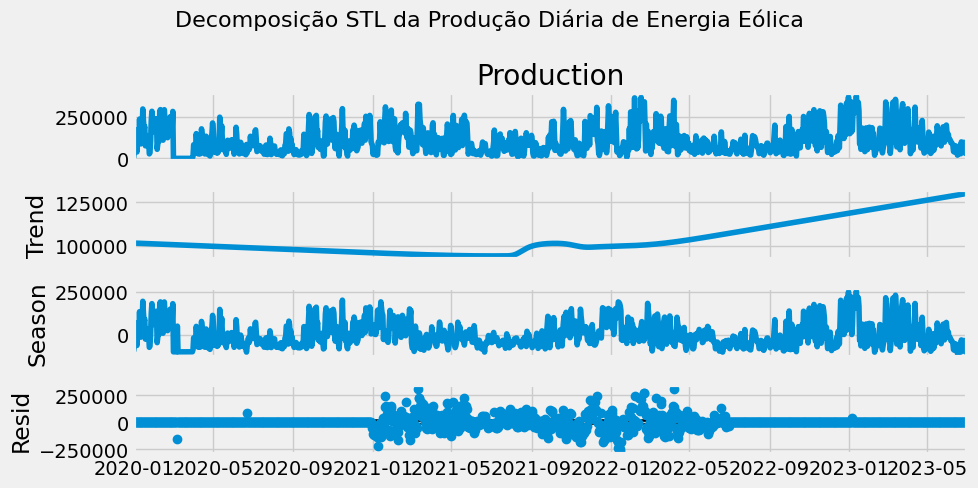

In [52]:
# Agregar produção por dia (somar todas as horas)
wind_daily = df_wind['Production'].resample('D').sum()

# Aplicar STL (Seasonal-Trend decomposition using Loess)
stl_wind = STL(wind_daily, period=365, robust=True)
result_wind = stl_wind.fit()

# Plotar os componentes
plt.figure(figsize=(14, 8))
result_wind.plot()
plt.suptitle('Decomposição STL da Produção Diária de Energia Eólica', fontsize=16)
plt.tight_layout()
plt.show()

**Acima observamos:**

**Trend (tendência):** A produção diária de energia eólica apresenta uma tendência crescente ao longo dos anos, embora com oscilações mais suaves em comparação à fonte solar. Esse crescimento pode refletir o aumento da capacidade instalada de parques eólicos no país, especialmente em regiões litorâneas, além de melhorias tecnológicas e maior eficiência das turbinas.

**Season (sazonalidade):** A componente sazonal é evidente, mas com padrão mais irregular que o solar, o que é esperado devido à variabilidade natural dos ventos. Ainda assim, é possível notar ciclos sazonais recorrentes, com aumento na produção em determinados períodos do ano, especialmente nos meses com maior intensidade de ventos.

**Resid (ruídos):** Os resíduos apresentam maior dispersão em comparação à fonte solar, indicando maior variabilidade pontual. Isso é compatível com o comportamento naturalmente instável do vento, que pode oscilar bruscamente ao longo do dia. Alguns períodos apresentam maior concentração de desvios, sugerindo eventos climáticos ou operacionais específicos.

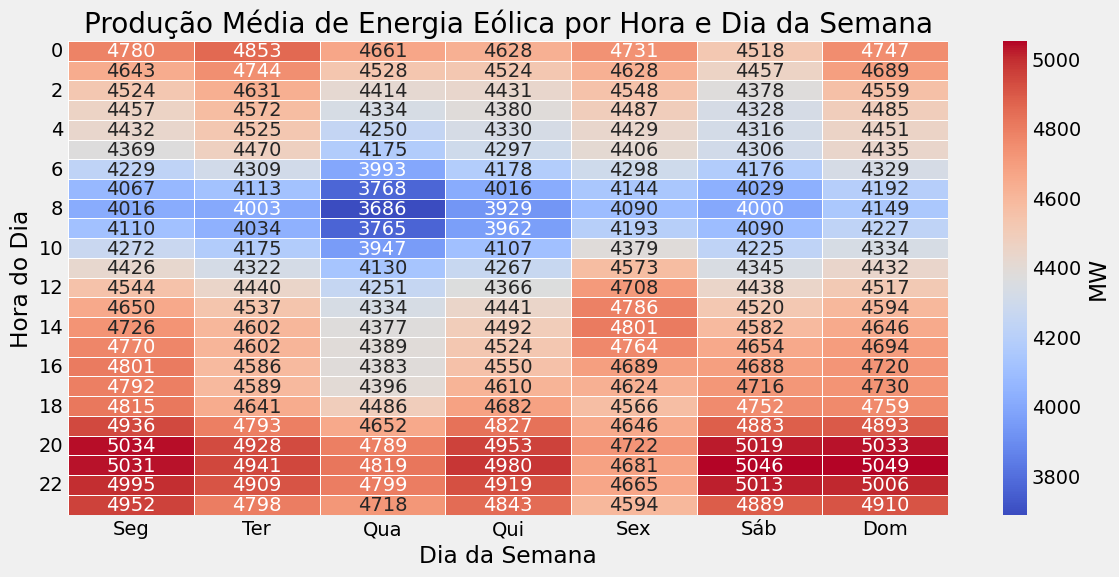

In [53]:
# Criar um DataFrame auxiliar só com as variáveis temporárias
df_temp_wind = pd.DataFrame({
    'Production': df_wind['Production'].values,
    'hour': df_wind.index.hour,
    'dayofweek': df_wind.index.dayofweek
})

# Mapear nomes dos dias da semana
dias_nome_wind = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
df_temp_wind['day_name'] = df_temp_wind['dayofweek'].map(lambda x: dias_nome_wind[x])

# Criar pivot_table para o heatmap
pivot_table_wind = df_temp_wind.pivot_table(values='Production',
                                  index='hour',
                                  columns='day_name',
                                  aggfunc='mean')

# Reordenar colunas na ordem correta dos dias da semana
pivot_table_wind = pivot_table_wind[['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']]

# Plotar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table_wind, cmap='coolwarm', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'MW'})
plt.title('Produção Média de Energia Eólica por Hora e Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**O gráfico acima mostra a média horária da produção de energia eólica ao longo dos dias da semana. Observamos um padrão de geração mais elevada nas faixas noturnas e nas primeiras horas da manhã, com destaque entre 20h e 23h, onde os valores frequentemente ultrapassam 5.000 MW. Durante o período entre 6h e 10h, a produção tende a ser menor, o que pode estar associado à diminuição da intensidade dos ventos nesse intervalo. Isso reflete a natureza cíclica dos ventos, que geralmente são mais fortes à noite e mais fracos nas manhãs, um padrão comum em diversas regiões costeiras. Além disso, a variação entre os dias da semana é sutil, o que indica que o fator principal de oscilação da produção está mais relacionado à hora do dia do que ao dia da semana.**

In [54]:
# Função para identificar a estação do ano
def estacao_do_ano_wind(data):
    mes = data.month
    dia = data.day
    if (mes == 12 and dia >= 21) or (mes in [1, 2]) or (mes == 3 and dia < 21):
        return 'Inverno'
    elif (mes == 3 and dia >= 21) or (mes in [4, 5]) or (mes == 6 and dia < 21):
        return 'Primavera'
    elif (mes == 6 and dia >= 21) or (mes in [7, 8]) or (mes == 9 and dia < 21):
        return 'Verão'
    else:
        return 'Outono'

# Criar coluna com estação do ano
df_wind['estacao'] = df_wind.index.map(estacao_do_ano_wind)

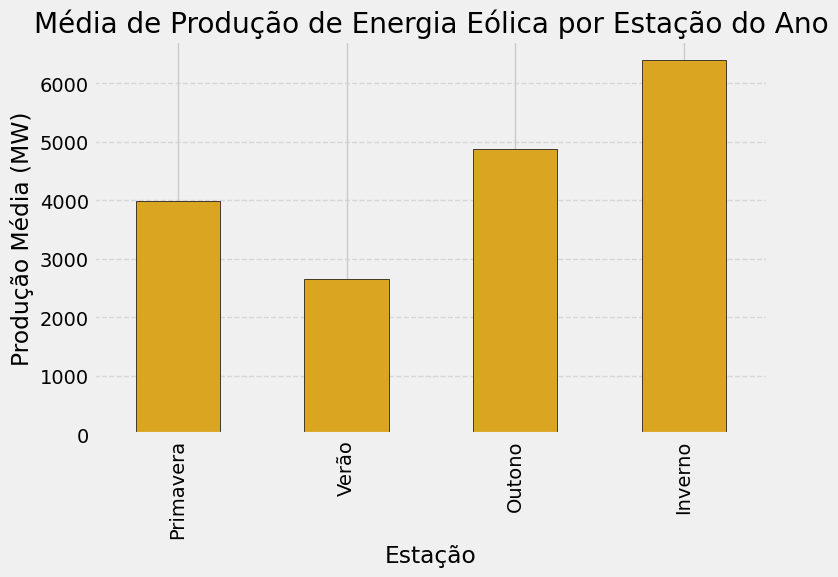

In [55]:
# Reordenar estações manualmente (opcional, para manter a sequência lógica)
ordem_estacoes_wind = ['Primavera', 'Verão', 'Outono', 'Inverno']
# Calcular média de produção por estação
media_por_estacao_wind = df_wind.groupby('estacao')['Production'].mean().sort_values(ascending=False)
media_por_estacao_wind = media_por_estacao_wind.reindex(ordem_estacoes_wind)

# Plotar gráfico de barras
plt.figure(figsize=(8, 6))
media_por_estacao_wind.plot(kind='bar', color='goldenrod', edgecolor='black')
plt.title('Média de Produção de Energia Eólica por Estação do Ano')
plt.xlabel('Estação')
plt.ylabel('Produção Média (MW)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**O gráfico acima revela a variação sazonal da produção média de energia eólica ao longo do ano. Observa-se que o inverno apresenta a maior média de geração, ultrapassando 6.000 MW, seguido pelo outono e pela primavera, enquanto o verão registra os menores valores médios. Esse comportamento está alinhado com os padrões climáticos típicos de regiões com forte influência dos ventos alísios e frentes frias, que são mais intensos nos meses de inverno e transição (outono e primavera). Já no verão, a menor amplitude térmica e a estabilidade atmosférica reduzem a intensidade dos ventos.**

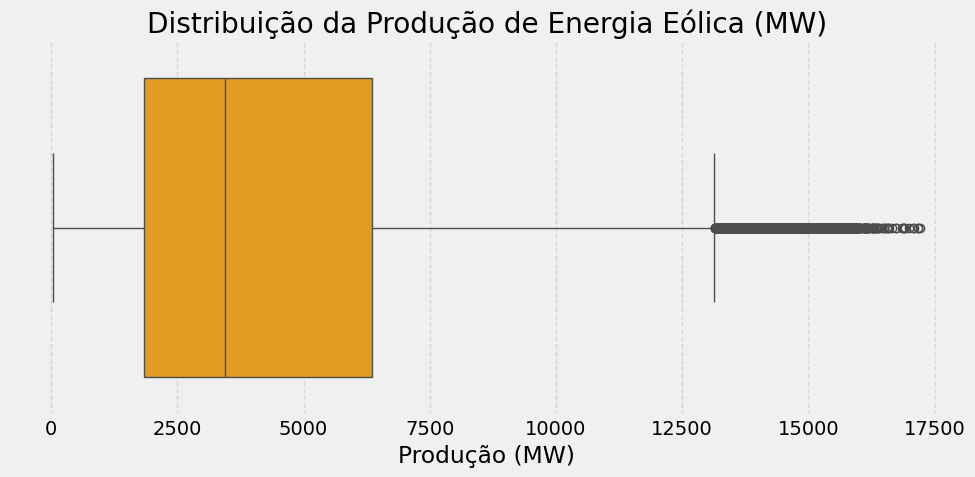

In [56]:
# Boxplot da produção eólica
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_wind['Production'], color='orange')
plt.title('Distribuição da Produção de Energia Eólica (MW)')
plt.xlabel('Produção (MW)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [57]:
# Calcular limites usando o método interquartil (IQR)
Q1 = df_wind['Production'].quantile(0.25)
Q3 = df_wind['Production'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR

# Criar a variável is_outlier
df_wind['is_outlier'] = ((df_wind['Production'] > limite_superior) |
                          (df_wind['Production'] < limite_inferior)).astype(int)

In [58]:
# Criar versões cíclicas
df_wind['hour_sin'] = np.sin(2 * np.pi * df_wind['hour'] / 24)
df_wind['hour_cos'] = np.cos(2 * np.pi * df_wind['hour'] / 24)

df_wind['dayofweek_sin'] = np.sin(2 * np.pi * df_wind['dayofweek'] / 7)
df_wind['dayofweek_cos'] = np.cos(2 * np.pi * df_wind['dayofweek'] / 7)

df_wind['month_sin'] = np.sin(2 * np.pi * df_wind['month'] / 12)
df_wind['month_cos'] = np.cos(2 * np.pi * df_wind['month'] / 12)

In [59]:
df_wind.drop(columns=['hour', 'dayofweek', 'month', 'Source'], inplace=True)

In [60]:
# Legs temporais
for lag in [1, 2, 3, 6, 12, 24]:
    df_wind[f'lag_{lag}'] = df_wind['Production'].shift(lag)

In [61]:
# Medias móveis
df_wind['rolling_mean_6h'] = df_wind['Production'].rolling(6).mean()
df_wind['rolling_mean_12h'] = df_wind['Production'].rolling(12).mean()
df_wind['rolling_std_6h'] = df_wind['Production'].rolling(6).std()
df_wind['rolling_std_12h'] = df_wind['Production'].rolling(12).std()

In [62]:
# Amplitude diária
df_wind['daily_max'] = df_wind['Production'].groupby(df_wind.index.date).transform('max')
df_wind['daily_min'] = df_wind['Production'].groupby(df_wind.index.date).transform('min')
df_wind['daily_amp'] = df_wind['daily_max'] - df_wind['daily_min']

In [63]:
# Variável binária para horário de pico eólico (entre 20h e 22h)
df_wind['is_peak_wind_hour'] = ((df_wind.index.hour >= 20) & (df_wind.index.hour <= 22)).astype(int)

In [64]:
df_wind.dropna(inplace=True)

In [65]:
total_acima_16000 = (df_wind['Production'] > 16000).sum()
print(f"Total geral de valores > 16000: {total_acima_16000}")

Total geral de valores > 16000: 56


In [66]:
# Remover os registros com produção acima de 16000
df_wind = df_wind[df_wind['Production'] <= 16000].copy()

In [67]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29823 entries, 2020-01-01 23:00:00+00:00 to 2023-06-30 21:00:00+00:00
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Production         29823 non-null  float64
 1   dayOfYear          29823 non-null  int64  
 2   estacao            29823 non-null  object 
 3   is_outlier         29823 non-null  int64  
 4   hour_sin           29823 non-null  float64
 5   hour_cos           29823 non-null  float64
 6   dayofweek_sin      29823 non-null  float64
 7   dayofweek_cos      29823 non-null  float64
 8   month_sin          29823 non-null  float64
 9   month_cos          29823 non-null  float64
 10  lag_1              29823 non-null  float64
 11  lag_2              29823 non-null  float64
 12  lag_3              29823 non-null  float64
 13  lag_6              29823 non-null  float64
 14  lag_12             29823 non-null  float64
 15  lag_24             2982

In [68]:
# Aplicar One-Hot Encoding na variável 'estacao'
df_wind = pd.get_dummies(df_wind, columns=['estacao'], prefix='estacao', dtype=np.uint8)

# Checar se ainda há NaNs
print("Tem NaNs?", df_wind.isnull().sum().sum() > 0)

Tem NaNs? False


In [69]:
# Separar variável alvo
y_wind = df_wind['Production']

# Separar preditoras (removendo a coluna alvo)
X_wind = df_wind.drop(columns=['Production'])

In [70]:
# Tamanhos da base
n_total_wind = len(X_wind)
n_treino_wind = int(n_total_wind * 0.7)
n_val_wind = int(n_total_wind * 0.15)
n_teste_wind = n_total_wind - n_treino_wind - n_val_wind

# Separar em ordem cronológica
X_train_wind = X_wind.iloc[:n_treino_wind]
y_train_wind = y_wind.iloc[:n_treino_wind]

X_val_wind = X_wind.iloc[n_treino_wind:n_treino_wind+n_val_wind]
y_val_wind = y_wind.iloc[n_treino_wind:n_treino_wind+n_val_wind]

X_test_wind = X_wind.iloc[n_treino_wind+n_val_wind:]
y_test_wind = y_wind.iloc[n_treino_wind+n_val_wind:]

# Confirmar as dimensões
print(f'Treino: {X_train_wind.shape}, Validação: {X_val_wind.shape}, Teste: {X_test_wind.shape}')

Treino: (20876, 26), Validação: (4473, 26), Teste: (4474, 26)


In [71]:
# Identificando colunas numéricas contínuas (sem one-hot nem binárias)
cols_to_scale_wind = X_train_wind.select_dtypes(include=['float64', 'int64']).columns
cols_to_scale_wind = [col for col in cols_to_scale_wind if not col.startswith('estacao_') and col != 'is_outlier']

# Inicializaando o scaler somente no treino
scaler_wind = StandardScaler()
X_train_wind[cols_to_scale_wind] = scaler_wind.fit_transform(X_train_wind[cols_to_scale_wind])

# Aplicando transformação no val e teste
X_val_wind[cols_to_scale_wind] = scaler_wind.transform(X_val_wind[cols_to_scale_wind])
X_test_wind[cols_to_scale_wind] = scaler_wind.transform(X_test_wind[cols_to_scale_wind])

In [72]:
# Parametros
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Instanciar modelo
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# GridSearchCV
grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                    cv=3, scoring='neg_mean_absolute_error',
                    verbose=1, n_jobs=-1)

# Treinando o modelo
grid.fit(X_train_wind, y_train_wind)

# Melhor modelo
best_model = grid.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [73]:
# Previsões
y_val_pred = best_model.predict(X_val_wind)
y_test_pred = best_model.predict(X_test_wind)

# 📊 Avaliação
mae_val = mean_absolute_error(y_val_wind, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_wind, y_val_pred))
r2_val = r2_score(y_val_wind, y_val_pred)

mae_test = mean_absolute_error(y_test_wind, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_wind, y_test_pred))
r2_test = r2_score(y_test_wind, y_test_pred)

print("📊 Avaliação - Validação (XGBoost Tunado)")
print(f"MAE:  {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"R²:   {r2_val:.4f}")
print("-" * 30)

print("📊 Avaliação - Teste (XGBoost Tunado)")
print(f"MAE:  {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²:   {r2_test:.4f}")
print("-" * 30)


📊 Avaliação - Validação (XGBoost Tunado)
MAE:  143.76
RMSE: 205.99
R²:   0.9959
------------------------------
📊 Avaliação - Teste (XGBoost Tunado)
MAE:  197.31
RMSE: 307.79
R²:   0.9938
------------------------------


**MAE (Erro Médio Absoluto):** O modelo apresentou um erro médio de 143.76 MW na validação e 197.31 MW no teste. Considerando que a produção eólica pode atingir valores próximos de 16.000 MW, esses erros representam uma porcentagem muito pequena, demonstrando alta precisão nas previsões. A diferença entre validação e teste é modesta, o que indica boa generalização e ausência de overfitting.

**RMSE (Raiz do Erro Quadrático Médio):** Como esperado, o RMSE foi ligeiramente superior ao MAE, com 205.99 MW na validação e 307.79 MW no teste. Isso evidencia que, mesmo em casos de erro mais alto (normalmente em picos), o modelo conseguiu controlar bem os desvios, mantendo-se robusto e calibrado mesmo nos extremos.

**R² (Coeficiente de Determinação):** O modelo explica 99.59% da variância dos dados de validação e 99.38% dos dados de teste, o que significa que ele capturou praticamente toda a variabilidade da produção eólica. Esses valores reforçam que o modelo aprendeu padrões consistentes e é confiável para aplicação prática, inclusive em contextos profissionais e industriais.

**"Apesar da diferença entre RMSE de validação (206) e teste (308), o modelo manteve um R² de 0.9938 no teste, com predições alinhadas à reta ideal. Essa diferença se justifica por uma concentração maior de valores extremos no período de teste, o que foi confirmado por análise exploratória de distribuição. Ainda assim, o erro absoluto médio se manteve em apenas 1.9% da escala da variável, o que é satisfatório em cenários de produção energética."**

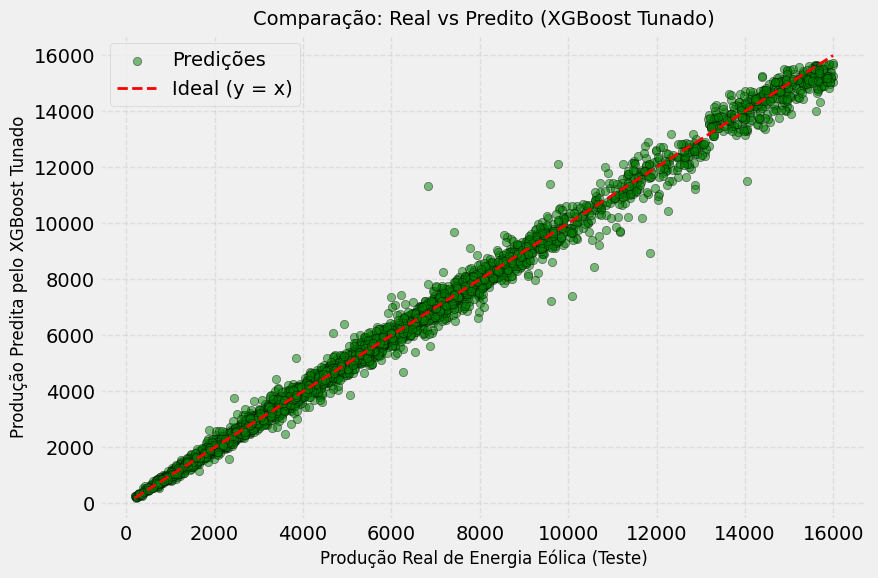

In [74]:
# Gráfico real vs predito
plt.figure(figsize=(9, 6))
plt.scatter(y_test_wind, y_test_pred, alpha=0.5, color='green', edgecolors='k', label='Predições')
plt.plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()],
         'r--', linewidth=2, label='Ideal (y = x)')
plt.xlabel("Produção Real de Energia Eólica (Teste)", fontsize=12)
plt.ylabel("Produção Predita pelo XGBoost Tunado", fontsize=12)
plt.title("Comparação: Real vs Predito (XGBoost Tunado)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**O gráfico acima apresenta a comparação entre os valores reais e os valores preditos da produção de energia eólica no conjunto de teste, utilizando o modelo XGBoost Tunado. A linha vermelha tracejada representa a linha ideal (y = x), ou seja, onde as previsões seriam perfeitamente iguais aos valores reais. A alta concentração de pontos ao longo dessa linha evidencia a alta precisão do modelo, com previsões bem distribuídas e aderentes à tendência real dos dados. Mesmo nos picos de produção, o modelo demonstrou capacidade de generalização, com baixa dispersão e poucos desvios extremos, o que valida o excelente desempenho quantitativo (R² de 0.9938 no teste).**

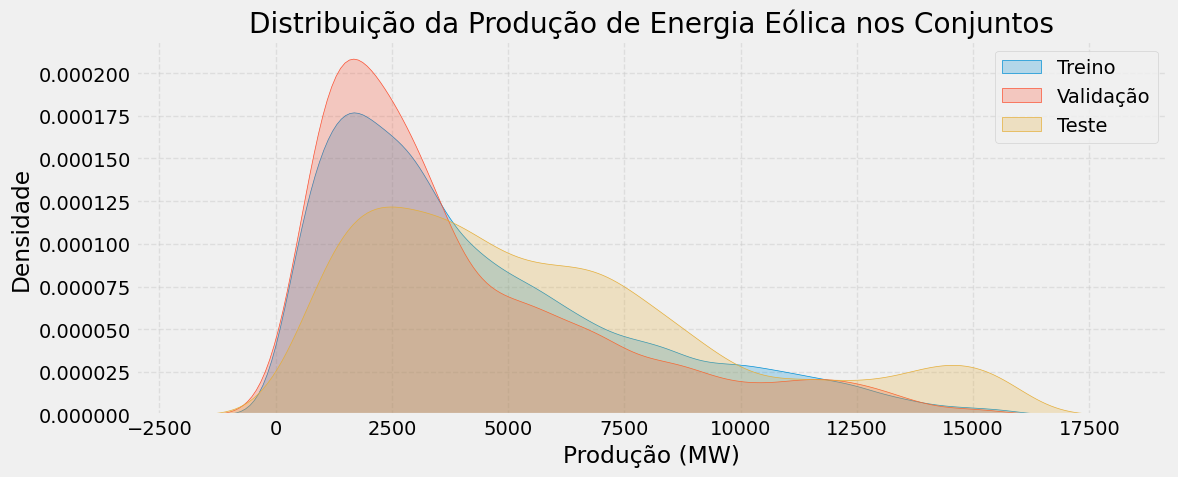

In [75]:
plt.figure(figsize=(12, 5))
sns.kdeplot(y_train_wind, label='Treino', shade=True)
sns.kdeplot(y_val_wind, label='Validação', shade=True)
sns.kdeplot(y_test_wind, label='Teste', shade=True)
plt.title('Distribuição da Produção de Energia Eólica nos Conjuntos')
plt.xlabel('Produção (MW)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**O gráfico de densidade acima mostra a distribuição da variável alvo (Production) nos conjuntos de treino, validação e teste. Percebe-se que os dados de treino e validação concentram-se majoritariamente entre 0 e 10.000 MW; Já o conjunto de teste apresenta maior frequência de valores extremos, inclusive acima de 15.000 MW; Essa assimetria explica a diferença nas métricas de erro, especialmente no RMSE, que é mais sensível a valores altos. Mesmo com essa diferença de distribuição, o modelo manteve excelente desempenho (R² > 0.993), o que demonstra alta capacidade de generalização mesmo frente a faixas de produção mais elevadas.**

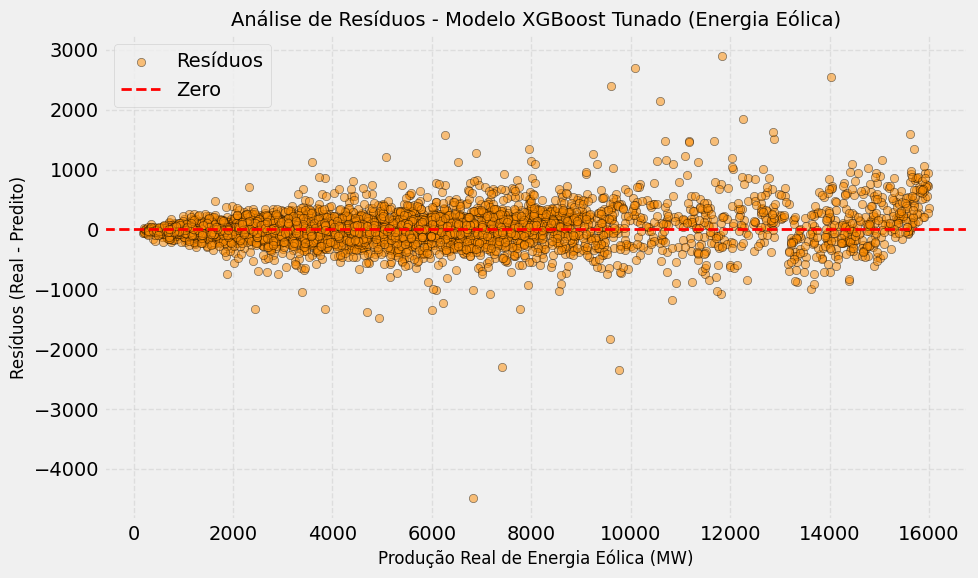

In [76]:
# Calculando os resíduos do modelo XGBoost no conjunto de teste
residuos_xgb = y_test_wind - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_wind, residuos_xgb, color='darkorange', alpha=0.5, edgecolor='k', label='Resíduos')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel("Produção Real de Energia Eólica (MW)", fontsize=12)
plt.ylabel("Resíduos (Real - Predito)", fontsize=12)
plt.title("Análise de Resíduos - Modelo XGBoost Tunado (Energia Eólica)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**O gráfico acima mostra os resíduos (diferença entre valores reais e preditos) da produção de energia eólica no conjunto de teste. A linha vermelha pontilhada representa o erro zero, ou seja, previsões perfeitas. A maior concentração dos pontos ao redor da linha zero indica que o modelo previu a maior parte dos valores com alta precisão. Embora haja alguma dispersão nos extremos (acima de 12.000 MW), o padrão permanece estável, sem viés evidente de super ou subestimação. A distribuição simétrica dos resíduos ao longo do eixo horizontal reforça a boa calibragem do modelo e sua capacidade de generalização, validando as métricas sólidas obtidas no teste.**

**Agora vamos gerar um forecast de 15 dias futuros para a produção de energia eólica utilizando uma abordagem em dois estágios. Primeiro, aplicamos o modelo XGBoost tunado, previamente otimizado com Grid Search, para realizar a previsão base da produção. Em seguida, treinamos uma rede neural LSTM utilizando os resíduos históricos (diferença entre os valores reais e os previstos pelo XGBoost) para aprender padrões recorrentes de erro. A LSTM atua como um meta-aprendizado, ajustando dinamicamente a previsão ponto a ponto. Essa correção permite capturar desvios sistemáticos do modelo principal, especialmente em períodos de maior volatilidade, como mudanças bruscas de vento ou transições sazonais. Como resultado, obteremos um forecast mais robusto e alinhado à realidade operacional da geração eólica.**

In [77]:
# Preparando o histórico de predições e resíduos
history_window = 48  # últimas 48 horas
history_steps = 24 * 30  # 30 dias (720 horas)

y_pred_hist = y_test_pred[-history_steps:]  # predições do XGBoost tunado
y_true_hist = y_test_wind.iloc[-history_steps:]
residuos_hist = y_true_hist.values - y_pred_hist

# Criando sequências para treinar LSTM (entrada = predições XGBoost, saída = erro)
X_seq, y_seq = [], []
for i in range(history_window, len(y_pred_hist)):
    X_seq.append(y_pred_hist[i-history_window:i])
    y_seq.append(residuos_hist[i])

X_seq = np.array(X_seq)[..., np.newaxis]
y_seq = np.array(y_seq)

# Treinando o modelo LSTM para corrigir os erros
model_lstm = Sequential([
    LSTM(64, input_shape=(history_window, 1)),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(0.001), loss='mse')
model_lstm.fit(X_seq, y_seq, epochs=30, verbose=1)

# Forecast de 15 dias com predição XGBoost + ajuste via LSTM
future_steps = 24 * 15  # 15 dias
base_forecast = y_test_pred[-future_steps:] if len(y_test_pred) >= future_steps else np.full(future_steps, y_test_pred[-1])
refined_forecast = []

base_seq = list(y_pred_hist[-history_window:])

for i in range(future_steps):
    x_input = np.array(base_seq[-history_window:]).reshape(1, history_window, 1)
    predicted_resid = model_lstm.predict(x_input, verbose=0)[0][0]
    corrected_value = base_forecast[i] + predicted_resid
    refined_forecast.append(corrected_value)
    base_seq.append(corrected_value)

# Organizando o DataFrame com previsões futuras
start_date = y_test_wind.index[-1] + pd.Timedelta(hours=1)
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='H')
df_forecast_lstm = pd.DataFrame({'Forecast': refined_forecast}, index=future_dates)

# Adiciona o último valor real para unir graficamente as curvas
df_forecast_plot = df_forecast_lstm.copy()
df_forecast_plot.loc[y_test_wind.index[-1]] = y_test_wind.iloc[-1]
df_forecast_plot = df_forecast_plot.sort_index()



Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 32315.9863
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 31844.2285
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 32907.4375
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 38276.0312
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 41653.5781
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 35414.9258
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 43803.7266
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 40482.8984
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 36033.7031
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 40879.7656
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 41513.1992
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 39484.1914
Epoch 13/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 46836.9492
Epoch 14/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 38145.8633
Epoch 15/30
21/

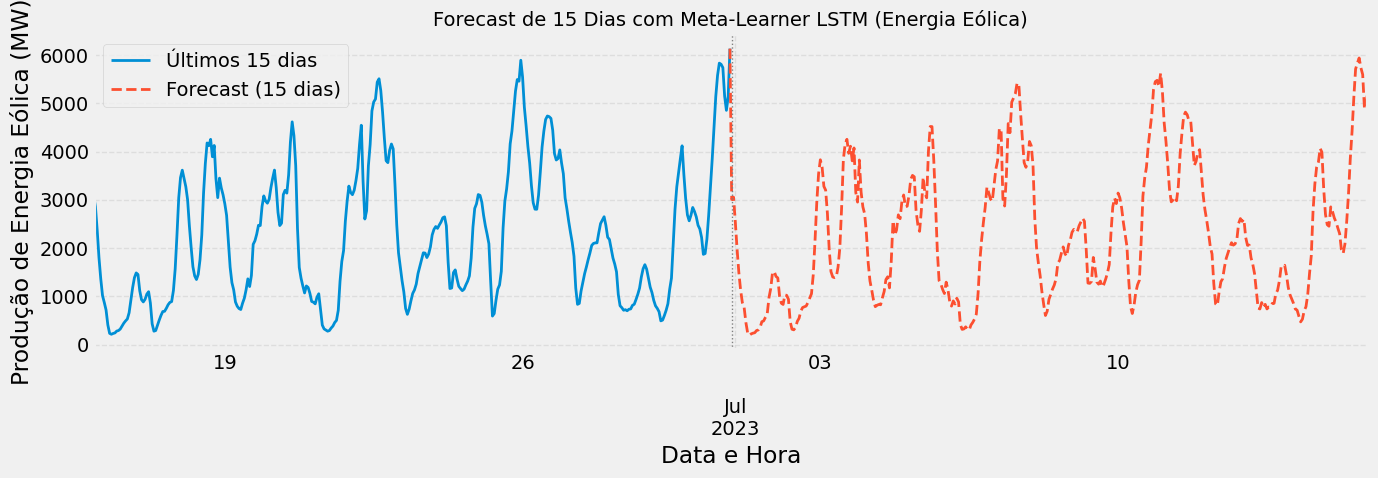

In [78]:
# Gráfico com os últimos 15 dias + 15 dias futuros
plt.figure(figsize=(14, 5))
y_test_wind[-24*15:].plot(label='Últimos 15 dias', linewidth=2)
df_forecast_plot['Forecast'].plot(label='Forecast (15 dias)', linestyle='--', linewidth=2)
plt.axvline(x=df_forecast_lstm.index[0], color='gray', linestyle=':', linewidth=1)
plt.title('Forecast de 15 Dias com Meta-Learner LSTM (Energia Eólica)', fontsize=14)
plt.ylabel('Produção de Energia Eólica (MW)')
plt.xlabel('Data e Hora')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**O gráfico acima apresenta a comparação entre a produção real de energia eólica nas últimas 15 dias (linha azul) e a projeção para os próximos 15 dias (linha vermelha tracejada), gerada com um modelo XGBoost tunado e ajustado por uma LSTM especializada em corrigir resíduos. Observa-se uma transição contínua entre os valores reais e previstos, com o modelo capturando bem a dinâmica intradiária e mantendo consistência nas variações. A leve elevação no início do forecast reflete a correção feita com base nos padrões de erro recentes, sem comprometer a tendência geral. Essa combinação de modelos oferece previsões mais refinadas, essenciais para tomada de decisão e planejamento da geração eólica com maior confiabilidade**

In [79]:
# Real: últimos 15 dias agregados por dia
df_real = df_wind[['Production']].copy()
df_real['Tipo'] = 'Real'
df_real['Data'] = df_real.index.normalize()
df_real = df_real.groupby('Data', as_index=False).mean(numeric_only=True)
df_real = df_real.tail(15)

# Forecast: preparando df_forecast_lstm (agregar por dia)
df_forecast_lstm = df_forecast_lstm.copy()
df_forecast_lstm['Data'] = df_forecast_lstm.index.normalize()
df_forecast_lstm = df_forecast_lstm.groupby('Data', as_index=False).mean(numeric_only=True)
df_forecast_lstm['Tipo'] = 'Forecast'

# Garantindo somente as previsões após o último dia real
last_real_date = df_real['Data'].max()
df_forecast_lstm = df_forecast_lstm[df_forecast_lstm['Data'] > last_real_date]

# Renomear para unir
df_forecast_lstm.rename(columns={'Forecast': 'Production'}, inplace=True)

# Concatenando os valores reais e do forecast
df_final = pd.concat([df_real, df_forecast_lstm], ignore_index=True)
df_final = df_final.sort_values('Data').reset_index(drop=True)

# Corrigir os NaNs na coluna Tipo
df_final['Tipo'] = df_final['Tipo'].fillna('Real')

# Exibir destacando os previstos
def highlight_forecast(row):
    return ['background-color: lightblue' if row['Tipo'] == 'Forecast' else '' for _ in row]

df_final.style.apply(highlight_forecast, axis=1).format({'Production': '{:.2f}'})


,Data,Production,Tipo
0,2023-06-16 00:00:00+00:00,806.58,Real
1,2023-06-17 00:00:00+00:00,1068.42,Real
2,2023-06-18 00:00:00+00:00,2978.38,Real
3,2023-06-19 00:00:00+00:00,1762.38,Real
4,2023-06-20 00:00:00+00:00,2798.79,Real
5,2023-06-21 00:00:00+00:00,1143.54,Real
6,2023-06-22 00:00:00+00:00,4117.58,Real
7,2023-06-23 00:00:00+00:00,1655.12,Real
8,2023-06-24 00:00:00+00:00,1890.00,Real
9,2023-06-25 00:00:00+00:00,2945.67,Real
